In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from sklearn import metrics
from sklearn import *
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
conn = sqlite3.connect("seckin_db.db")

In [3]:
cur = conn.cursor()

In [20]:
cur.execute("select * from entries limit 500")

In [21]:
results = cur.fetchall()

In [22]:
cur.execute('PRAGMA TABLE_INFO({})'.format('entries'))
names = [tup[1] for tup in cur.fetchall()]
print(names)

['time', 'duration', 'srcDevice', 'dstDevice', 'protocol', 'srcPort', 'dstPort', 'srcPackets', 'dstPackets', 'srcBytes', 'dstBytes']


In [23]:
# desired = names[7:]
# print(desired)

In [45]:

newList = []
for i in results:
#     print(i[7:])
    newList.append(i[7:])

print(newList)

[(1665, 1108, 300810, 250408), (1866, 0, 1477041, 0), (3326, 0, 2656305, 0), (5423, 0, 4388449, 0), (7061, 0, 5745536, 0), (8638, 0, 7052947, 0), (9943, 0, 8105139, 0), (11544, 0, 9398696, 0), (13011, 0, 10586412, 0), (14876, 0, 12128980, 0), (16366, 0, 13365368, 0), (18213, 0, 14897583, 0), (19467, 0, 15924693, 0), (20703, 0, 16920558, 0), (21922, 0, 17905913, 0), (23159, 0, 18931121, 0), (24344, 0, 19914020, 0), (25816, 0, 21135448, 0), (27333, 0, 22393722, 0), (28257, 0, 23149303, 0), (0, 387956, 0, 528637071), (2702, 3219, 226968, 296148), (5445, 6438, 457380, 592296), (9296, 11957, 780864, 1100044), (12773, 15636, 1072932, 1438512), (15801, 19775, 1327284, 1819300), (17015, 21155, 1429260, 1946260), (4504, 3544, 951517, 632127), (2673, 3219, 224532, 296148), (5307, 6438, 445788, 592296), (9031, 11033, 758604, 1015036), (12076, 15169, 1014384, 1395548), (5462, 4692, 1116322, 791041), (0, 625559, 0, 870655259), (0, 351743, 0, 476432504), (0, 634155, 0, 882924509), (2693, 3217, 22621

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(newList))

In [48]:
X_normalized.columns = ['srcPackets','dstPackets','srcBytes','dstBytes']

In [49]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_normalized)
y_kmeans = kmeans.predict(X_normalized)

In [51]:
centers = kmeans.cluster_centers_
print('Cluster centers of columns:\n')
print(pd.DataFrame(centers,columns= ['srcPackets','dstPackets','srcBytes','dstBytes']))

Cluster centers of columns:

   srcPackets  dstPackets  srcBytes  dstBytes
0    0.005165    0.001748  0.008387  0.005240
1    0.999883    0.999991  0.999874  0.999962


# Implementing Elbow Method

In [52]:
from sklearn import metrics
from scipy.spatial.distance import cdist

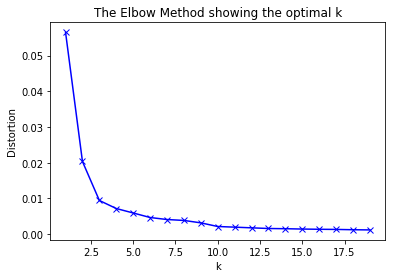

In [53]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_normalized)
    kmeanModel.fit(X_normalized)
    distortions.append(sum(np.min(cdist(X_normalized, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_normalized.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Average Solhouette Method

In [54]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [55]:
cluster_range = range( 2, 10 )

for n_clusters in cluster_range:
  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict( X_normalized )

  silhouette_avg = silhouette_score(X_normalized, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X_normalized, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.9854249300759831
For n_clusters = 3 The average silhouette_score is : 0.9582150834583992
For n_clusters = 4 The average silhouette_score is : 0.9566700733166021
For n_clusters = 5 The average silhouette_score is : 0.9450450109127277
For n_clusters = 6 The average silhouette_score is : 0.9230322455237308
For n_clusters = 7 The average silhouette_score is : 0.9264364145947288
For n_clusters = 8 The average silhouette_score is : 0.9270637250817274
For n_clusters = 9 The average silhouette_score is : 0.8828771913752693


# Mean-Shift Clustering

In [56]:
from sklearn.cluster import MeanShift, estimate_bandwidth

ms = MeanShift(bin_seeding=True)
ms.fit(X_normalized)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 12


# Gaussian Mixture Models

In [57]:
from sklearn.cluster import MeanShift, estimate_bandwidth

ms = MeanShift(bin_seeding=True)
ms.fit(X_normalized)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 12


# New Column

In [87]:
resultsCopy = []
for i in results:
    newList = []
    for j in i:
        newList.append(j)
    resultsCopy.append(newList)
    

In [94]:
labels = kmeans.labels_
# print(resultsCopy)
# print(labels)
j = 0
for i in resultsCopy:
    i.append(labels[j])
    j = j+1

print(resultsCopy)
    

[['118783', '6976', 'Comp450942', 'Comp829338', 6, 'Port03137', 445, 1665, 1108, 300810, 250408, 0], ['118785', '14178', 'IP564116', 'Comp141988', 17, 5060, 5060, 1866, 0, 1477041, 0, 0], ['118785', '28147', 'IP564116', 'Comp141988', 17, 5060, 5060, 3326, 0, 2656305, 0, 0], ['118785', '48507', 'IP564116', 'Comp141988', 17, 5060, 5060, 5423, 0, 4388449, 0, 0], ['118785', '63173', 'IP564116', 'Comp141988', 17, 5060, 5060, 7061, 0, 5745536, 0, 0], ['118785', '78594', 'IP564116', 'Comp141988', 17, 5060, 5060, 8638, 0, 7052947, 0, 0], ['118785', '90763', 'IP564116', 'Comp141988', 17, 5060, 5060, 9943, 0, 8105139, 0, 0], ['118785', '104427', 'IP564116', 'Comp141988', 17, 5060, 5060, 11544, 0, 9398696, 0, 0], ['118785', '115677', 'IP564116', 'Comp141988', 17, 5060, 5060, 13011, 0, 10586412, 0, 0], ['118785', '135078', 'IP564116', 'Comp141988', 17, 5060, 5060, 14876, 0, 12128980, 0, 0], ['118785', '148289', 'IP564116', 'Comp141988', 17, 5060, 5060, 16366, 0, 13365368, 0, 0], ['118785', '167723

In [97]:
print(resultsCopy[312])

['119169', '65450', 'Comp004479', 'Comp274690', 6, 'Port17617', 2049, 188026938, 1106033761, 18245057412, 45578036816, 1]


In [102]:
print("NEW TABLE! Kinda...")

print("['time', 'duration', 'srcDevice', 'dstDevice', 'protocol', 'srcPort', 'dstPort', 'srcPackets', 'dstPackets', 'srcBytes', 'dstBytes', cluster]")
for i in resultsCopy:
    print(i)

NEW TABLE! Kinda...
['time', 'duration', 'srcDevice', 'dstDevice', 'protocol', 'srcPort', 'dstPort', 'srcPackets', 'dstPackets', 'srcBytes', 'dstBytes', cluster]
['118783', '6976', 'Comp450942', 'Comp829338', 6, 'Port03137', 445, 1665, 1108, 300810, 250408, 0]
['118785', '14178', 'IP564116', 'Comp141988', 17, 5060, 5060, 1866, 0, 1477041, 0, 0]
['118785', '28147', 'IP564116', 'Comp141988', 17, 5060, 5060, 3326, 0, 2656305, 0, 0]
['118785', '48507', 'IP564116', 'Comp141988', 17, 5060, 5060, 5423, 0, 4388449, 0, 0]
['118785', '63173', 'IP564116', 'Comp141988', 17, 5060, 5060, 7061, 0, 5745536, 0, 0]
['118785', '78594', 'IP564116', 'Comp141988', 17, 5060, 5060, 8638, 0, 7052947, 0, 0]
['118785', '90763', 'IP564116', 'Comp141988', 17, 5060, 5060, 9943, 0, 8105139, 0, 0]
['118785', '104427', 'IP564116', 'Comp141988', 17, 5060, 5060, 11544, 0, 9398696, 0, 0]
['118785', '115677', 'IP564116', 'Comp141988', 17, 5060, 5060, 13011, 0, 10586412, 0, 0]
['118785', '135078', 'IP564116', 'Comp141988',

In [25]:
cur.close()

In [26]:
conn.close()